<h3>Import packages</h3>

In [1]:
from datetime import date
from timeit import default_timer as timer
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import load_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Load Model</h3>

In [2]:
model = load_model('Saved Models/8 cat/mobilenet_84p(90_10_split).h5')

<h3>Create train and test folder</h3>

In [3]:
#creates a folder each time the set of code is run to sort dataset into train and test
day = date.today()
formatDate = day.strftime("%b-%d-%Y")

#create folder with current date to group predictions ran in a day together, if it does not exists
if os.path.isdir('Prediction (' + formatDate + ')') is False:
    folder = os.mkdir('Prediction (' + formatDate + ')')
folder = 'Prediction (' + formatDate + ')'

#looping through to find if destination folder exists
i = 1
while True:
    if os.path.isdir(folder + '/Battery Images - ' + str(i)) is False:
        break
    i += 1

#destination path for unsorted folder
destination = folder + '/Battery Images - ' + str(i)

#source path for unsorted folder
# source = 'Battery Images/'
# source = 'Battery Images [Old]/'
# source = 'Battery Images [StreamLined]/'
source = 'Battery Images [Download]/'

#duplicate the unsorted folder from source to destination
shutil.copytree(source, destination)

os.mkdir(destination + '/train')
os.mkdir(destination + '/test')

<h3>Sort dataset into train and test folder</h3>

In [4]:
#function to split images into training (80%) and testing (20%) and return both
def split(data):
    # num = int(len(data) * 0.8)
    num = int(len(data) * 0.9) #90/10 split
#     num = int(len(data) * 0.7) #70/30 split
    random.shuffle(data)
    return data[:num], data[num:]

dir = os.chdir(destination)
for category in os.listdir(dir):
    #skip the iteration if folder is "train" or "test"
    skip = ['train', 'test']
    if category in skip:
        continue
    
    shutil.move(f'{category}', 'train')
    #create a subfolder with the same name in test
    os.mkdir(f'test/{category}')

    #get the images in each folder (battery type) for spltting of data into training and testing
    img = os.listdir(f'train/{category}')
    training, testing = split(img)
    
    for file in testing:
        shutil.move(f'train/{category}/{file}', f'test/{category}')

<h3>Process data</h3>

In [5]:
train_path = 'train'
test_path = 'test'

#for data augmentation on training data
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    # validation_split=0.2,
    validation_split=0.1, #changes made for 90/10 split
    rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
#     vertical_flip = False,    # randomly flip images
    vertical_flip = True, #include vertical flip for better generalisation
    )  

#takes images from directory path and generates batches of augmented data
train = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    subset='training',
        shuffle = False)

#for validation data
# validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, 
#                                         validation_split=0.2)
validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input, 
                                        validation_split=0.1) #changes made for 90/10 split


validation = validation_batches.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=32,
    subset='validation',
        shuffle = False)

#for test data
test = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224,224), batch_size=32, shuffle=False)

Found 691 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 89 images belonging to 8 classes.


<h3>Evaluate Test data</h3>

In [6]:
testLoss, testAcc = model.evaluate(test)
print('''
Test Loss: {}
Test Accuracy: {}
'''.format(testLoss, testAcc))

c:\Users\ngden\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 [==============================] - 6s 807ms/step - loss: 0.0179 - accuracy: 1.0000

Test Loss: 0.017916910350322723
Test Accuracy: 1.0



<h3>Classification report</h3>

In [7]:
predictions = model.predict(test, verbose=0)
# predictions = predictions.reshape(1,-1)[0]
lst = np.argmax(predictions, axis= 1)

print(classification_report(test.classes, lst, target_names = test.class_indices))

              precision    recall  f1-score   support

    Duracell       1.00      1.00      1.00        14
   Energizer       1.00      1.00      1.00        14
    Eveready       1.00      1.00      1.00        10
       Exell       1.00      1.00      1.00         9
          GP       1.00      1.00      1.00        12
        Ikea       1.00      1.00      1.00         9
      Klarus       1.00      1.00      1.00        11
   Panasonic       1.00      1.00      1.00        10

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



<h3>Confusion matrix</h3>

[[14  0  0  0  0  0  0  0]
 [ 0 14  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0]
 [ 0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0 10]]


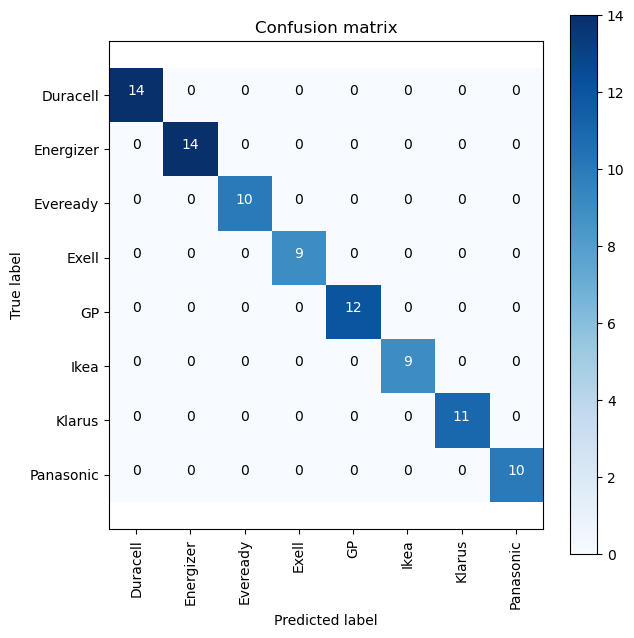

In [8]:
result = confusion_matrix(test.classes, lst)
print(result)

def plot_confusion_matrix(result, classes, cmap=plt.cm.Blues):
    plt.subplots(figsize=(7, 7))
    plt.imshow(result, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

    thresh = result.max() / 2.
    for i, j in itertools.product(range(result.shape[0]), range(result.shape[1])):
        plt.text(j, i, result[i, j],
            horizontalalignment="center",
            color = "white" if result[i, j] > thresh else "black")
        
    #current matplotlib version will cut off top and bottom of the matrix, 
    #hence the manual workaround - remove if matplotlib version does not cut off
    b, t = plt.ylim() # discover bottom and top values
    b += 0.5 # Add 0.5 to bottom
    t -= 0.5 # Subtract 0.5 from top
    plt.ylim(b, t) # update ylim(bottom, top) values
    plt.show()
    
plot_confusion_matrix(result, list(test.class_indices.keys()))

<h3>Labels of wrong predictions</h3>

In [9]:
def getErrors(test, predictions):
    #get file names of all images in test data
    names = test.filenames

    #get IDs of all classes
    allClassesID = test.classes

    #get dictionary of classes and respective ID
    classLabelDict = test.class_indices
    
    #list of the names of all classes
    classLabels = list(classLabelDict.keys())

    print("The list of classes: ", classLabels)

    #get the most predicted class
    predictedClasses = np.argmax(predictions, axis=1)

    predictedErrors = np.where(predictedClasses != allClassesID)[0]

    print("Number of errors = {}/{}".format(len(predictedErrors),test.samples))

    return classLabels, predictedErrors, names

def showErrors(classLabels, predictedErrors, predictions, names):
    # Show the errors
    for i in range(len(errors)):
        predictedClass = np.argmax(predictions[predictedErrors[i]])

        predictedLabel = classLabels[predictedClass]

        title = 'Original Picture : {}, Prediction : {}, Confidence/Percentage : {:.3f}'.format\
                (names[predictedErrors[i]].split('/')[0],predictedLabel, predictions[errors[i]][predictedClass])
        print(title)

In [10]:
#get the list of class labels, prediction errors and file names
labels, errors, names = getErrors(test, predictions)

#show wrongly predicted images, prediction and and the percentage (confidence)
showErrors(labels, errors, predictions, names)

The list of classes:  ['Duracell', 'Energizer', 'Eveready', 'Exell', 'GP', 'Ikea', 'Klarus', 'Panasonic']
Number of errors = 0/89
